In [18]:
import sys
import os
sys.path.append('/Users/adam2392/Documents/tvb/')
# sys.path.append('/Users/adam2392/Documents/tvb/_tvbdata/')
# sys.path.append('/Users/adam2392/Documents/tvb/_tvblibrary/')
# from tvb.simulator.lab import *
import numpy as np
import pandas as pd
import scipy
from sklearn import cluster
import tvbsim

import processing.util as util
import processing.preprocessfft as preprocess

from natsort import natsorted

import tvbsim.util

sys.path.append('/Users/adam2392/Documents/dnn-unsupervised/dnn/')
import processing.util as util

from sklearn.decomposition import PCA
import matplotlib
from matplotlib import *
from matplotlib import pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2

import ntpath
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

def _gettimepoints(numsignals, numwinsamps, numstepsamps):
    # create array of indices of window start times
    timestarts = np.arange(0, numsignals-numwinsamps+1, numstepsamps)
    # create array of indices of window end times
    timeends = np.arange(numwinsamps-1, numsignals, numstepsamps)
    # create the timepoints array for entire data array
    timepoints = np.append(timestarts.reshape(len(timestarts), 1), timeends.reshape(len(timestarts), 1), axis=1)
    return timepoints

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Define Where Data Is

We need to get the data that is stored as FFT data.

We need to transform the data from 
- rawdataset is [numchans, numtimepoints]
- freqdata is the rawdata preprocessed into frequency data
[numchannels, numfrequencybands, numtimewindows]
- imagedata is freqdata reformatted into images
[width, height, numfreqbands, numtimewindows]

In [17]:
datadir = '/Volumes/ADAM LI/pydata/output/frequencyanalysis/'
datadir = '/Users/adam2392/Documents/dnn-unsupervised/dnn/traindata/'
metadatadir = '/Volumes/ADAM LI/pydata/metadata/'    

# Get ALL datafiles from all downstream files
datafiles = []
for root, dirs, files in os.walk(datadir):
    for file in files:
        if file.endswith(".npz"):
             datafiles.append(os.path.join(root, file))
print(datafiles)

['/Users/adam2392/Documents/dnn-unsupervised/dnn/traindata/id001_ac_nez1_npz1_34.npz', '/Users/adam2392/Documents/dnn-unsupervised/dnn/traindata/id001_ac_nez1_npz1_21.npz', '/Users/adam2392/Documents/dnn-unsupervised/dnn/traindata/id014_rb_nez1_npz0_45.npz', '/Users/adam2392/Documents/dnn-unsupervised/dnn/traindata/id014_rb_nez1_npz0_51.npz', '/Users/adam2392/Documents/dnn-unsupervised/dnn/traindata/id001_ac_nez1_npz0_49.npz', '/Users/adam2392/Documents/dnn-unsupervised/dnn/traindata/id002_cj_nez1_npz1_17.npz', '/Users/adam2392/Documents/dnn-unsupervised/dnn/traindata/id001_ac_nez1_npz1_9.npz', '/Users/adam2392/Documents/dnn-unsupervised/dnn/traindata/id014_rb_nez1_npz1_11.npz', '/Users/adam2392/Documents/dnn-unsupervised/dnn/traindata/id014_rb_nez1_npz1_1.npz', '/Users/adam2392/Documents/dnn-unsupervised/dnn/traindata/id002_cj_nez1_npz1_29.npz', '/Users/adam2392/Documents/dnn-unsupervised/dnn/traindata/id014_rb_nez1_npz1_12.npz', '/Users/adam2392/Documents/dnn-unsupervised/dnn/trainda

In [4]:
'''
This code segment should only be ran once, to extract metadata for each patient, 
so it doesn't need to be done in the loop for FFT compression.

EXTRACTS LOCATION DATA FOR EACH PATIENT
'''
patients = []
# get all patients in the dataset
for datafile in datafiles:
    filename = path_leaf(datafile)
    patient = '_'.join(filename.split('_')[0:2])
    if patient not in patients:
        patients.append(patient)
print(patients)

patient_dict = {}

# get all metadata for each patient
for patient in patients:
    project_dir = os.path.join(metadatadir, patient)
    confile = os.path.join(project_dir, "connectivity.zip")

    # get the regions, and region_centers from connectivity
    reader = util.ZipReader(confile)
    region_centers = reader.read_array_from_file("centres", use_cols=(1, 2, 3))
    regions = reader.read_array_from_file("centres", dtype=np.str, use_cols=(0,))
    
    # load in the vertices, normals and areas of gain matrix
    use_subcort = True
    verts, _, areas, regmap = tvbsim.util.read_surf(project_dir, use_subcort)
    
    patient_dict['project_dir'] = project_dir
    patient_dict['regions'] = regions
    patient_dict['region_centers'] = region_centers
    patient_dict['surf_data'] = (verts, areas, regmap)

['id001_ac', 'id002_cj', 'id014_rb']


# 2. Go Through Each Data File and Create Final Image Dataset

- imagedata is freqdata reformatted into images
[width, height, numfreqbands, numtimewindows]

Use functions to
- project 3D -> 2D coordinates
- mesh that 2D image with an imagesize and perform cubic interpolation
- create image

*Need labels [numsamples] that is {0,1} for when onset/offset is*

In [15]:
# define the data handler 
datahandler = util.DataHandler()
pca = PCA(n_components=2)

AZIM=0

# loop through each data file and get grid
for idx,datafile in enumerate(datafiles):
    # load data
    data = np.load(datafile, encoding='bytes')
    power = data['power']
    print(power.shape)
    print(data.keys())
#     print(metadata.keys())
    
    # load xyz data for this particular dataset
    xyz_data = data['locs']
    
    # project xyz data
    if AZIM==1:
        print("using azim projection to grid image")
        new_locs = []
        for ichan in range(0,xyz_data.shape[0]):
            new_locs.append(datahandler.azim_proj(xyz_data[ichan,:]))
        new_locs = np.asarray(new_locs)
    if AZIM==0:
        print("using pca to grid image")
        new_locs = pca.fit_transform(xyz_data)
     
    # Tensor of size [samples, freqbands, W, H] containing generated images.
#     image_tensor = datahandler.gen_images(new_locs, power, 
#                                 n_gridpoints=32, normalize=True, augment=True, 
#                                 pca=False, std_mult=0.1, edgeless=False)
    
    # 

    print(new_locs.shape)
    break

(70, 4, 647)
['power', 'timepoints', 'seiztimes', 'locs', 'seeg_contacts', 'x0ez']
using pca to grid image
(647, 70)
(70, 2)lating 647/647nterpolating 57/647Interpolating 87/647Interpolating 121/647Interpolating 161/647Interpolating 205/647Interpolating 240/647Interpolating 277/647Interpolating 316/647Interpolating 356/647Interpolating 393/647Interpolating 428/647Interpolating 463/647Interpolating 498/647Interpolating 528/647Interpolating 560/647Interpolating 600/647Interpolating 628/647


(647, 4, 32, 32)


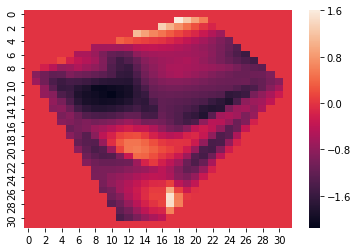

In [16]:
print(image_tensor.shape)
np.save('test_image.npy', image_tensor)
sns.heatmap(image_tensor[0,0,:,:].squeeze())

2.5


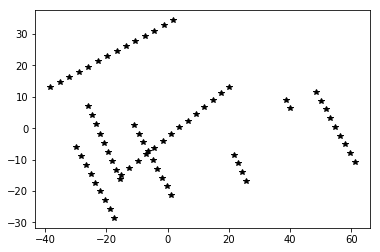

In [8]:
print(5/2)
pca_xyz = new_locs
fig = plt.figure()
plt.plot(pca_xyz[:,0], pca_xyz[:,1], 'k*')

fig = plt.figure()
# plt.plot(pca_locs[:,0], pca_locs[:,1], 'k*')

In [ ]:
# lists to store the list of tuples of seizure onset/offsets
seizuremarks = []

# list to store the last time point of each recording added in
timelens = []

for idx,datafile in enumerate(datafiles):
    powerbands, timepoints = preprocessor.compresspowermat(datafile)
    onsettimes, offsettimes = preprocessor.getseiztimes(datafile)
    
    metadata = preprocessor.loadmetadata(datafile)
    metadata['regions'] = regions
    metadata['region_centers'] = region_centers
    
    # get the last time point
    lasttimewin = timepoints[-1,:][1]+1
    timelens.append(lasttimewin)
    
    if idx > 0:
        onsettimes = list(np.asarray(onsettimes) + np.sum(timelens[0:idx-1]))
        offsettimes = list(np.asarray(offsettimes) + np.sum(timelens[0:idx-1]))
    seizuremarks_tuple = list(zip(onsettimes,offsettimes)) 
    seizuremarks.append(seizuremarks_tuple)
#     mapped_power_bands = preprocessor.projectpower_gain(powerbands,
#                                                         metadata,
#                                                        verts,
#                                                        areas,
#                                                        regmap)
#     print(mapped_power_bands.shape)
#     mapped_power_bands = preprocessor.projectpower_knn(powerbands,
#                                                         metadata)
#     print(mapped_power_bands.shape)
    mapped_power_bands = preprocessor.projectpower_invsquare(powerbands,
                                                        metadata)
#     print(onsettimes, offsettimes)
#     print(powerbands.keys())
#     print(powerbands[list(powerbands.keys())[0]].shape)
#     print(mapped_power_bands.shape)

    if idx == 0:
        condensed_power = mapped_power_bands
    else:
        condensed_power = np.concatenate((condensed_power, mapped_power_bands), axis=0)

print(condensed_power.shape)
print(seizuremarks)
print(timelens)